In [1]:
# --- Thư viện Xử lý Dữ liệu ---
import pandas as pd
import numpy as np
import re
import warnings
import joblib

# --- Thư viện Machine Learning (Scikit-learn) ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Thư viện Trực quan hóa ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cài đặt Môi trường ---
# Tắt các cảnh báo không quan trọng
warnings.filterwarnings('ignore')
# Cài đặt để Pandas hiển thị tất cả các cột
pd.set_option('display.max_columns', None)
# Cài đặt style cho biểu đồ đẹp hơn
sns.set(style='whitegrid', rc={'font.size': 10, 'axes.labelsize': 12})

print("Tất cả thư viện đã được nhập (import). Sẵn sàng!")

Tất cả thư viện đã được nhập (import). Sẵn sàng!


In [4]:
df1 = pd.read_csv("C:/Users/Acer/Desktop/PMNM/Tapdulieu/bang_1.csv")
df2 = pd.read_csv("C:/Users/Acer/Desktop/PMNM/Tapdulieu/bang_2.csv")
df3 = pd.read_csv("C:/Users/Acer/Desktop/PMNM/Tapdulieu/bang_3.csv")

In [5]:
def standardize_province_name(name):
    """
    Hàm trợ giúp:
    Làm sạch và chuẩn hóa tên tỉnh về một định dạng chung.
    """
    name = str(name).strip()
    # Bỏ các tiền tố chung
    name = re.sub(r'^(TP\. |Tỉnh |Thành phố )', '', name)
    # Chuẩn hóa các trường hợp đặc biệt
    if 'Hồ Chí Minh' in name:
        return 'TP. Hồ Chí Minh'
    if 'Huế' in name or 'Thừa Thiên' in name:
        return 'Thừa Thiên Huế'
    if 'Bà Rịa' in name:
        return 'Bà Rịa - Vũng Tàu'
    if 'Đắk Lắk' in name:
        return 'Đắk Lắk'
    if 'Đắk Nông' in name:
        return 'Đắk Nông'
    return name

print("Đã định nghĩa hàm 'standardize_province_name'.")

Đã định nghĩa hàm 'standardize_province_name'.


In [6]:
print("Bước 2 & 3: Đang tiền xử lý, tạo đặc trưng và hợp nhất...")

# --- Xử lý Bảng 2 (GSO) ---
df2.rename(columns={
    'nam': 'Nam', 'dan so': 'DanSo', 'dan so thanh thi': 'DanSoThanhThi',
    'grdp_binh quan': 'GRDP_BinhQuan', 'TenTinh': 'TinhThanh'
}, inplace=True)
df2['TyLeThanhThi'] = (df2['DanSoThanhThi'] / df2['DanSo']) * 100
df2 = df2.drop(columns=['DanSoThanhThi'])

# --- Xử lý Bảng 3 (DVC) ---
df3['TinhThanh'] = df3['TinhThanh'].str.replace(r'^(UBND tỉnh |UBND Thành phố |UBND )', '', regex=True)

# --- Chuẩn hóa tên tỉnh (sử dụng hàm từ Cell 3) ---
print("... Đang chuẩn hóa tên tỉnh ở cả 3 bảng...")
df1['TinhThanh'] = df1['TinhThanh'].apply(standardize_province_name)
df2['TinhThanh'] = df2['TinhThanh'].apply(standardize_province_name)
df3['TinhThanh'] = df3['TinhThanh'].apply(standardize_province_name)

# --- Hợp nhất (INNER JOIN) ---
df_merged = pd.merge(df1, df2, on=['TinhThanh', 'Nam'], how='inner')
master_df = pd.merge(df_merged, df3, on=['TinhThanh', 'Nam'], how='inner')

print(f"\nDữ liệu sau khi hợp nhất (INNER JOIN) có: {master_df.shape[0]} dòng và {master_df.shape[1]} cột.")
print("\n--- 5 Dòng đầu của Bảng Tổng hợp (master_df) ---")
display(master_df.head())

print("\n--- Thông tin (info) của Bảng Tổng hợp ---")
master_df.info()

Bước 2 & 3: Đang tiền xử lý, tạo đặc trưng và hợp nhất...
... Đang chuẩn hóa tên tỉnh ở cả 3 bảng...

Dữ liệu sau khi hợp nhất (INNER JOIN) có: 102 dòng và 16 cột.

--- 5 Dòng đầu của Bảng Tổng hợp (master_df) ---


,TinhThanh,DTI_Tong,DTI_ChinhQuyenSo,DTI_KinhTeSo,DTI_XaHoiSo,HaTangSo,Nam,DanSo,GRDP_BinhQuan,TyLeThanhThi,TongDiem_DVC,CongKhaiMinhBach,TienDoGiaiQuyet,DichVuTrucTuyen,MucDoHaiLong,SoHoaHoSo
0,Đà Nẵng,0.8002,0.8575,0.7836,0.5197,0.8253,2022,1220.2,102.0,87.452877,56.32,7.71,17.30,5.82,16.30,9.19
1,TP. Hồ Chí Minh,0.7163,0.8406,0.7611,0.3590,0.8258,2022,9389.7,159.4,77.722398,59.84,3.92,19.40,3.54,17.73,15.25
2,Quảng Ninh,0.7024,0.8385,0.5904,0.4505,0.7648,2022,1362.9,197.7,67.253650,57.67,5.87,19.08,5.58,17.76,9.38
3,Thừa Thiên Huế,0.6975,0.8262,0.6787,0.3001,0.6823,2022,1160.2,57.0,52.818480,58.43,9.34,16.49,5.79,16.97,9.84
4,Cần Thơ,0.6924,0.7325,0.7556,0.2947,0.7233,2022,1252.3,87.0,70.502276,53.91,8.69,16.40,5.39,16.93,6.50



--- Thông tin (info) của Bảng Tổng hợp ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TinhThanh         102 non-null    object 
 1   DTI_Tong          102 non-null    float64
 2   DTI_ChinhQuyenSo  102 non-null    float64
 3   DTI_KinhTeSo      102 non-null    float64
 4   DTI_XaHoiSo       102 non-null    float64
 5   HaTangSo          102 non-null    float64
 6   Nam               102 non-null    int64  
 7   DanSo             102 non-null    float64
 8   GRDP_BinhQuan     102 non-null    float64
 9   TyLeThanhThi      102 non-null    float64
 10  TongDiem_DVC      102 non-null    float64
 11  CongKhaiMinhBach  102 non-null    float64
 12  TienDoGiaiQuyet   102 non-null    float64
 13  DichVuTrucTuyen   102 non-null    float64
 14  MucDoHaiLong      102 non-null    float64
 15  SoHoaHoSo         102 non-null    float64
dtype

In [7]:
print("Bước 4: Đang xây dựng bộ đặc trưng (X) và biến mục tiêu (y)...")

# Biến mục tiêu (y)
y = master_df['DTI_Tong']

# Biến đặc trưng (X)
feature_columns = [
    'HaTangSo', 'DanSo', 'GRDP_BinhQuan', 'TyLeThanhThi',
    'CongKhaiMinhBach', 'TienDoGiaiQuyet', 'DichVuTrucTuyen',
    'MucDoHaiLong', 'SoHoaHoSo'
]
X = master_df[feature_columns]

# Xử lý NaN (nếu có - Mặc dù info() báo không có, đây là bước phòng vệ tốt)
if X.isnull().sum().sum() > 0:
    print("...Phát hiện giá trị NaN, đang điền bằng giá trị trung bình...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].mean(), inplace=True)
            
print(f"Đã tạo X (với {X.shape[1]} đặc trưng) và y.")

print("\n--- 5 Dòng đầu của Bảng Đặc trưng (X) ---")
display(X.head())

Bước 4: Đang xây dựng bộ đặc trưng (X) và biến mục tiêu (y)...
Đã tạo X (với 9 đặc trưng) và y.

--- 5 Dòng đầu của Bảng Đặc trưng (X) ---


,HaTangSo,DanSo,GRDP_BinhQuan,TyLeThanhThi,CongKhaiMinhBach,TienDoGiaiQuyet,DichVuTrucTuyen,MucDoHaiLong,SoHoaHoSo
0,0.8253,1220.2,102.0,87.452877,7.71,17.30,5.82,16.30,9.19
1,0.8258,9389.7,159.4,77.722398,3.92,19.40,3.54,17.73,15.25
2,0.7648,1362.9,197.7,67.253650,5.87,19.08,5.58,17.76,9.38
3,0.6823,1160.2,57.0,52.818480,9.34,16.49,5.79,16.97,9.84
4,0.7233,1252.3,87.0,70.502276,8.69,16.40,5.39,16.93,6.50


In [8]:
print("Bước 5: Đang chuẩn hóa (Scaling) và chia dữ liệu (Splitting)...")

# 1. Chuẩn hóa đặc trưng (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Chia dữ liệu (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Chia dữ liệu hoàn tất:")
print(f"  - Tập huấn luyện (Train): {X_train.shape[0]} mẫu")
print(f"  - Tập kiểm thử (Test):   {X_test.shape[0]} mẫu")

Bước 5: Đang chuẩn hóa (Scaling) và chia dữ liệu (Splitting)...
Chia dữ liệu hoàn tất:
  - Tập huấn luyện (Train): 81 mẫu
  - Tập kiểm thử (Test):   21 mẫu


In [9]:
print("Bước 6: Đang huấn luyện và tối ưu Random Forest...")

# 1. Khởi tạo mô hình
rf_model = RandomForestRegressor(random_state=42)

# 2. Định nghĩa các "thiết lập" (tham số) để "dò"
param_grid = {
    'n_estimators': [50, 100, 150], # Số lượng "cây"
    'max_depth': [5, 10, None],     # Độ sâu
    'min_samples_leaf': [1, 2, 4]  # Mẫu tối thiểu ở 1 "lá"
}

# 3. Khởi tạo GridSearchCV
print("... Bắt đầu dò tìm tham số tốt nhất (GridSearchCV)...")
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, 
                           scoring='r2', n_jobs=-1, verbose=1)

# 4. Huấn luyện (Fit) - Quá trình này có thể mất vài giây
grid_search.fit(X_train, y_train)

# 5. Lấy ra mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

print(f"\nĐÃ TỐI ƯU XONG! Tham số tốt nhất tìm được: {grid_search.best_params_}")

Bước 6: Đang huấn luyện và tối ưu Random Forest...
... Bắt đầu dò tìm tham số tốt nhất (GridSearchCV)...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

ĐÃ TỐI ƯU XONG! Tham số tốt nhất tìm được: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 150}


In [10]:
print("Bước 7: Đang đánh giá mô hình tốt nhất trên tập Test...")

# 1. Dự đoán trên tập Test
y_pred_rf = best_rf_model.predict(X_test)

# 2. Tính toán "độ chính xác" (R-squared) và Lỗi (MSE)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("\n--- KẾT QUẢ RANDOM FOREST TỐI ƯU ---")
print(f"  R-squared (R2): {r2_rf:.4f} (tức {r2_rf:.2%})")
print(f"  Mean Squared Error (MSE): {mse_rf:.4f}")

Bước 7: Đang đánh giá mô hình tốt nhất trên tập Test...

--- KẾT QUẢ RANDOM FOREST TỐI ƯU ---
  R-squared (R2): 0.6707 (tức 67.07%)
  Mean Squared Error (MSE): 0.0037


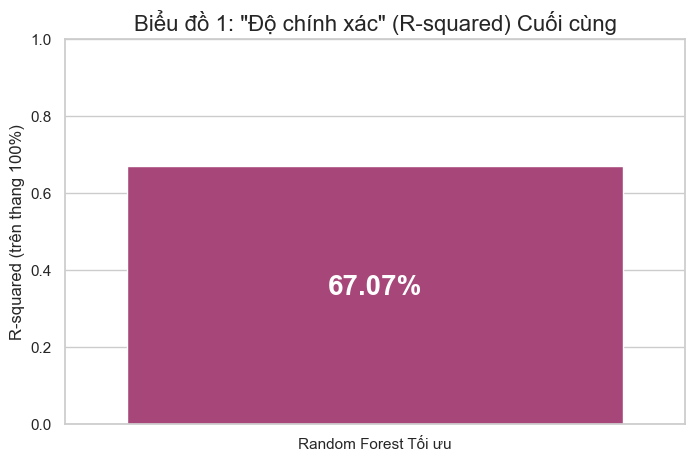

In [11]:
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(
    x=['Random Forest Tối ưu'], 
    y=[r2_rf], 
    palette='magma'
)

# Thêm nhãn %
bar_plot.text(0, r2_rf / 2, f"{r2_rf:.2%}", 
              color='white', ha='center', fontsize=20, fontweight='bold')

plt.title('Biểu đồ 1: "Độ chính xác" (R-squared) Cuối cùng', fontsize=16)
plt.ylabel('R-squared (trên thang 100%)')
plt.ylim(0, 1.0)
plt.show()

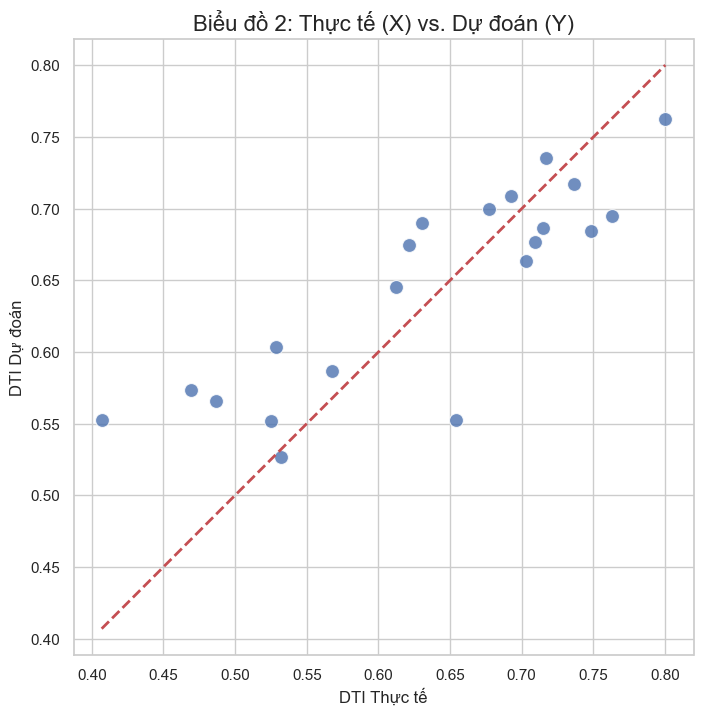

In [12]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.8, s=100)

# Vẽ đường thẳng hoàn hảo (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Biểu đồ 2: Thực tế (X) vs. Dự đoán (Y)', fontsize=16)
plt.xlabel('DTI Thực tế', fontsize=12)
plt.ylabel('DTI Dự đoán', fontsize=12)
plt.axis('equal') # Đảm bảo 2 trục có cùng tỷ lệ
plt.grid(True)
plt.show()

Bước 8: Phân tích mức độ quan trọng của đặc trưng...


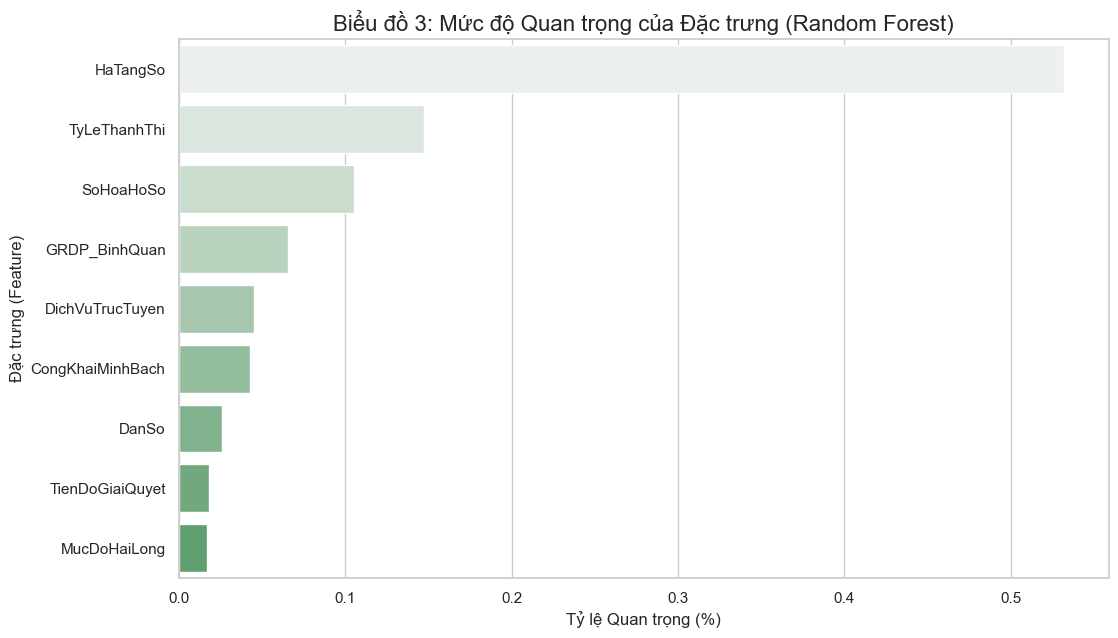


Bảng Mức độ Quan trọng (từ cao đến thấp):


,Feature,Importance
0,HaTangSo,0.532132
3,TyLeThanhThi,0.147208
8,SoHoaHoSo,0.105482
2,GRDP_BinhQuan,0.065802
6,DichVuTrucTuyen,0.045057
4,CongKhaiMinhBach,0.043002
1,DanSo,0.026266
5,TienDoGiaiQuyet,0.018162
7,MucDoHaiLong,0.016887


In [13]:
print("Bước 8: Phân tích mức độ quan trọng của đặc trưng...")

# 1. Lấy dữ liệu Importance từ mô hình
rf_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False) # Sắp xếp

# 2. Vẽ biểu đồ cột ngang
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=rf_importances, palette='light:g')
plt.title('Biểu đồ 3: Mức độ Quan trọng của Đặc trưng (Random Forest)', fontsize=16)
plt.xlabel('Tỷ lệ Quan trọng (%)', fontsize=12)
plt.ylabel('Đặc trưng (Feature)', fontsize=12)
plt.show()

# 3. In ra DataFrame
print("\nBảng Mức độ Quan trọng (từ cao đến thấp):")
display(rf_importances)

In [14]:
print("Bước 9: Đang lưu các tệp kết quả...")

# 1. Định nghĩa tên file
model_name = "random_forest_model.joblib"
scaler_name = "features_scaler.joblib"
data_name = "master_data_cleaned_merged.csv"

# 2. Lưu 3 file
joblib.dump(best_rf_model, model_name)
joblib.dump(scaler, scaler_name)
master_df.to_csv(data_name, index=False, encoding='utf-8-sig')

print("\n--- HOÀN TẤT ---")
print(f"Đã lưu thành công 3 file:")
print(f"  1. Mô hình:   {model_name}")
print(f"  2. Scaler:    {scaler_name}")
print(f"  3. Dữ liệu:   {data_name}")

Bước 9: Đang lưu các tệp kết quả...

--- HOÀN TẤT ---
Đã lưu thành công 3 file:
  1. Mô hình:   random_forest_model.joblib
  2. Scaler:    features_scaler.joblib
  3. Dữ liệu:   master_data_cleaned_merged.csv
